# Linear Regression

## Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split,validation_curve,GridSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

## Load data

In [2]:
df = pd.read_csv('data/dataset.csv')
df = df[df['genre'].notnull()]
df = df.drop(['track', 'artist', 'uri'], axis=1)
df.head(5)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade,genre
1,0.498,0.505,3,-12.475,1,0.0337,0.0180,0.107000,0.1760,0.797,101.801,213613,4,48.82510,10,0,60,pop
6,0.662,0.272,0,-18.883,1,0.0313,0.3600,0.228000,0.0963,0.591,143.507,134360,4,47.82155,7,0,60,jazz
9,0.511,0.603,2,-7.637,1,0.0280,0.0385,0.000002,0.1420,0.685,128.336,157293,4,43.36534,9,1,60,pop
11,0.520,0.411,9,-12.411,1,0.0315,0.7860,0.001200,0.1460,0.350,120.290,207573,4,37.54527,9,1,60,pop
13,0.746,0.666,2,-10.408,1,0.1460,0.5430,0.000000,0.0488,0.840,94.024,192427,4,78.59848,5,1,60,country


## Visualizations

Similar to the KNN regression we will use energy and loudness here as well

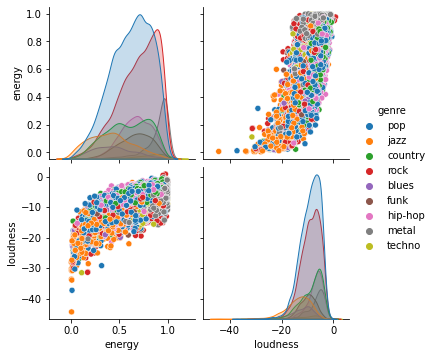

In [3]:
sns.pairplot(df[['energy', 'loudness', 'genre']], hue='genre')

<AxesSubplot:>

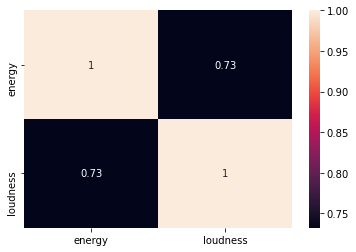

In [4]:
sns.heatmap(df[['energy', 'loudness']].corr(), annot=True)

## Helper functions

In [5]:
def fit_summary(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
    print(f'MSE: {mean_squared_error(y_test, y_pred)}')
    print(f'R2 score: {r2_score(y_test, y_pred)}')

In [6]:
def plot_prediction_curve(model, X_test, y_test):
    x_np = np.array(X)
    xfit = np.linspace(min(x_np), max(x_np), 1000)
    yfit = model.predict(xfit)
    plt.figure(figsize=(20, 10))
    plt.scatter(X_test, y_test, s=5, alpha=0.4)
    plt.plot(xfit, yfit, color='red')
    plt.xlabel('energy')
    plt.ylabel('loudness')

In [7]:
def plot_residuals(model, X_test, y_test):
    y_pred = model.predict(X_test)
    residual = y_test - y_pred
    plt.figure(figsize=(20, 10))
    # for x_predict, y_residual in zip(y_pred, residual):
    #     plt.plot([x_predict, x_predict], [0, y_residual], c='red', lw=1, alpha=0.4)
    sns.scatterplot(x=y_pred, y=residual, s=10)
    plt.axhline(0, c='black', linestyle=':')
    plt.xlabel('y_pred')
    plt.ylabel('residual')
    plt.title('Residuals')

In [8]:
def plot_validation_curve(estimator, x, y, *, param_name, param_range, cv):
    train_scores, test_scores = validation_curve(
        estimator, x, y, param_name=param_name, param_range=param_range, cv=cv
    )
    train_scores_mean = train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)
    plt.figure(figsize=(20, 10))
    plt.title('Validation Curve')
    plt.xlabel('alpha')
    plt.ylabel('Score')
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label='Training score',
                 color='darkorange', lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color='darkorange', lw=lw)
    plt.plot(param_range, test_scores_mean, label='Test score',
                 color='navy', lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color='navy', lw=lw)
    plt.xticks(param_range)
    plt.legend(loc='best')

## Linear regression

### Train test split

In [9]:
X = df[['energy']]
y = df['loudness']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Original data

#### sklearn linear regression

In [11]:
model_linear = LinearRegression()
fit_summary(model_linear, X_train, X_test, y_train, y_test)
print(f'Coefficients W: {model_linear.coef_}')
print(f'Intercept W0: {model_linear.intercept_}')

MAE: 2.1972558546276177
MSE: 7.543957250197372
R2 score: 0.5510612259143275
Coefficients W: [13.49115389]
Intercept W0: -17.616281874680226


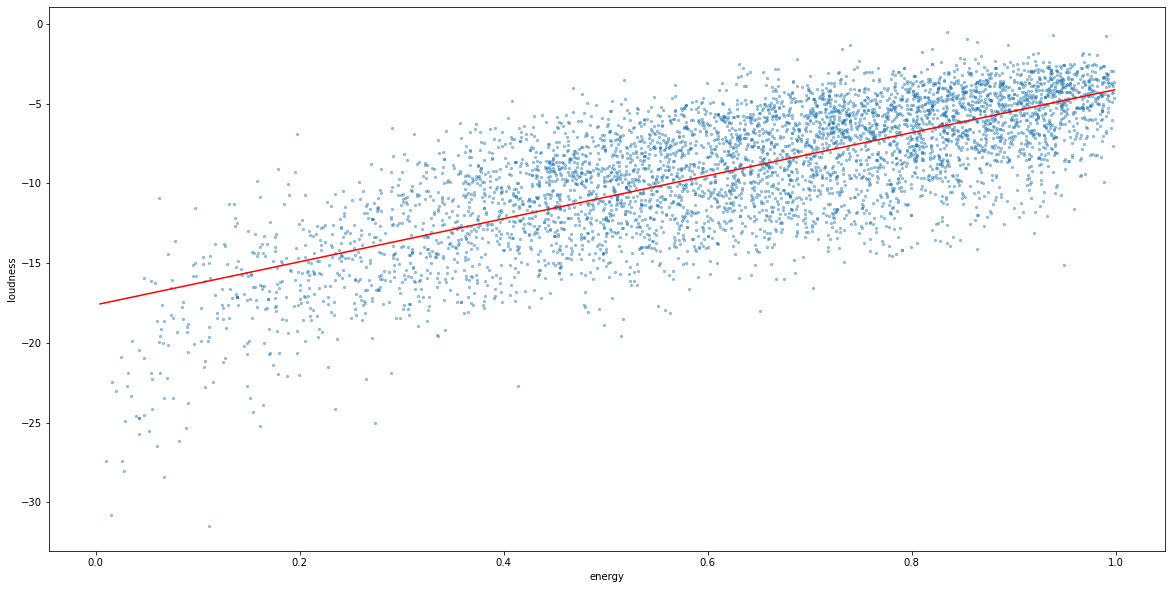

In [12]:
plot_prediction_curve(model_linear, X_test, y_test)

#### statsmodels

In [13]:
regressor = sm.OLS(y_train, X_train).fit()
regressor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               loudness   R-squared (uncentered):                   0.579
Model:                            OLS   Adj. R-squared (uncentered):              0.579
Method:                 Least Squares   F-statistic:                          2.092e+04
Date:                Thu, 13 May 2021   Prob (F-statistic):                        0.00
Time:                        16:11:00   Log-Likelihood:                         -50007.
No. Observations:               15230   AIC:                                  1.000e+05
Df Residuals:                   15229   BIC:                                  1.000e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
energy       -11.2507      0.078   -144.627      0.000     -11.403     -11.098
==============================================================================
Omnibus:                     1506.176   Durbin-Watson:                   1.825
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2067.036
Skew:                          -0.804   Prob(JB):                         0.00
Kurtosis:                       3.821   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Residuals

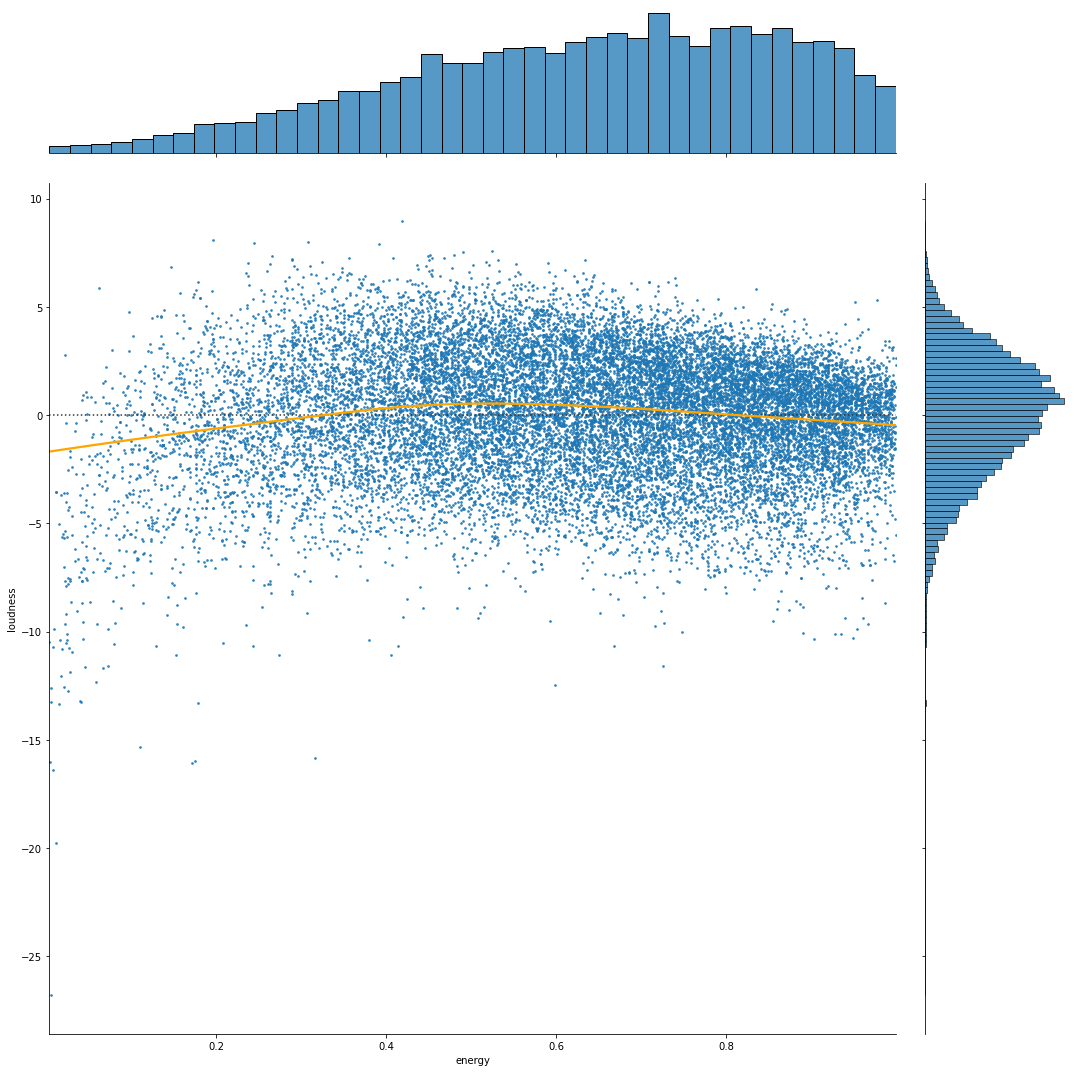

In [14]:
sns.jointplot(x='energy', y='loudness', data=df, kind='resid', lowess=True, line_kws={'color': 'orange'}, scatter_kws={'s': 3, 'alpha': 0.8}, height=15)

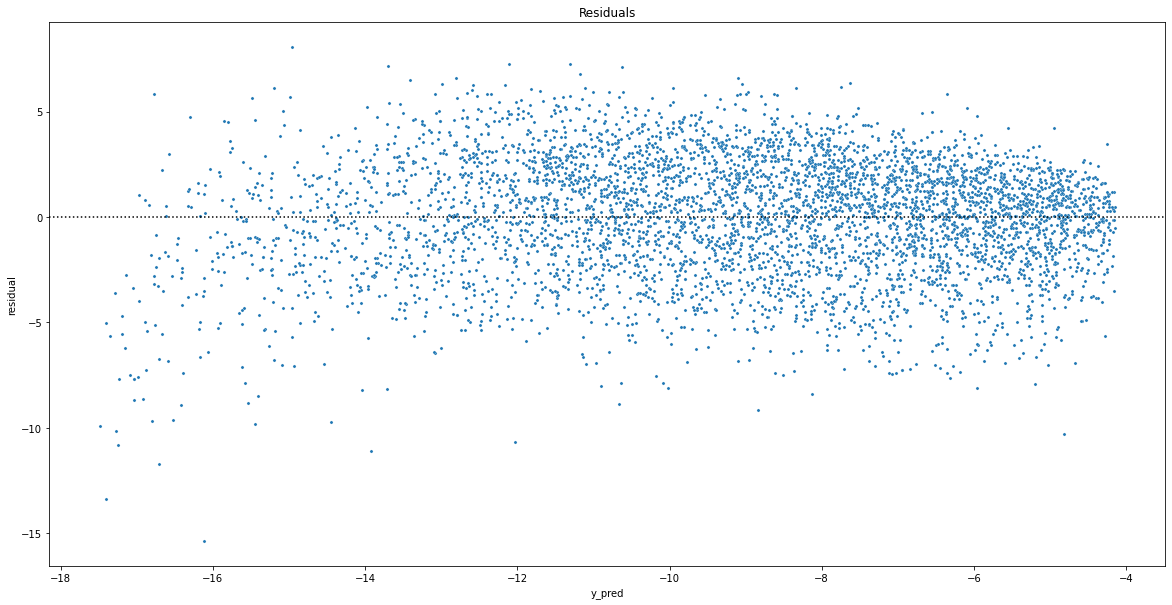

In [15]:
plot_residuals(model_linear, X_test, y_test)

### Polynomial features

In [16]:
poly_model = make_pipeline(PolynomialFeatures(8), LinearRegression())
fit_summary(poly_model, X_train, X_test, y_train, y_test)

MAE: 2.1539983937521714
MSE: 7.112612902769508
R2 score: 0.576730406706409


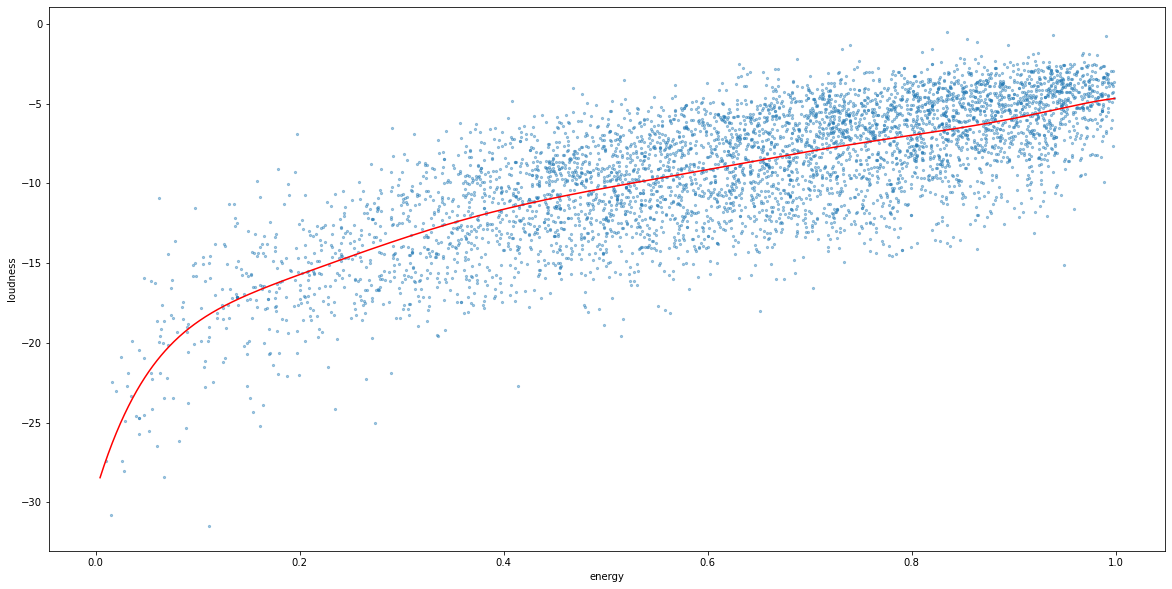

In [17]:
plot_prediction_curve(poly_model, X_test, y_test)

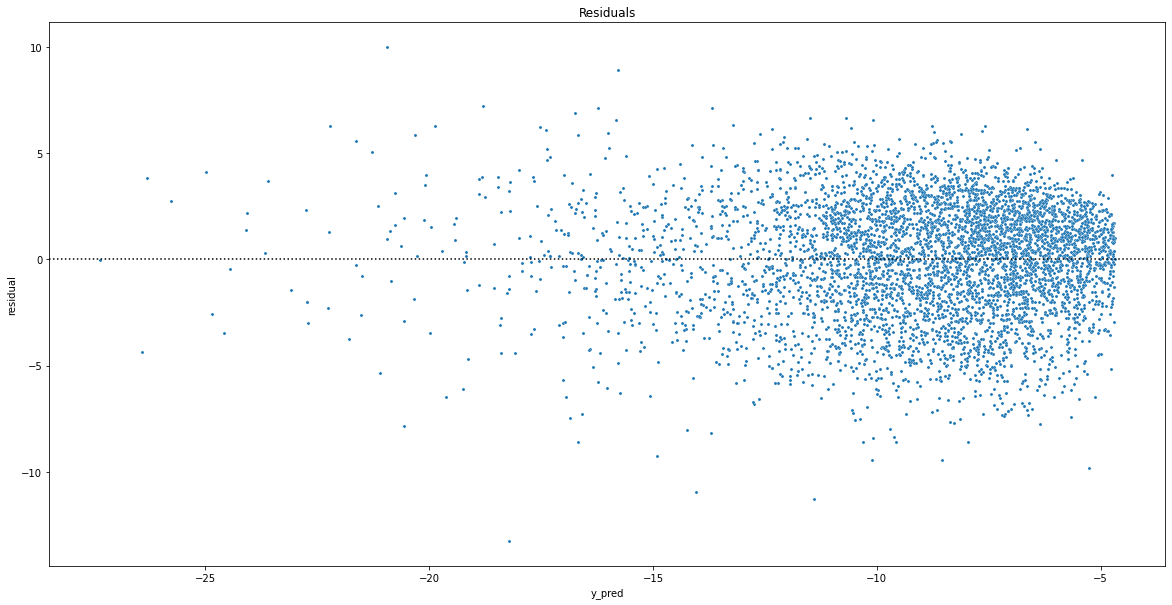

In [18]:
plot_residuals(poly_model, X_test, y_test)

#### Conclusion

We observe that using polynomial features matches the lower end of the data better

## Lasso regression

In [19]:
model_lasso = Lasso(alpha=0.05)
fit_summary(model_lasso, X_train, X_test, y_train, y_test)

MAE: 2.212095894293668
MSE: 7.608783423605689
R2 score: 0.547203438568325


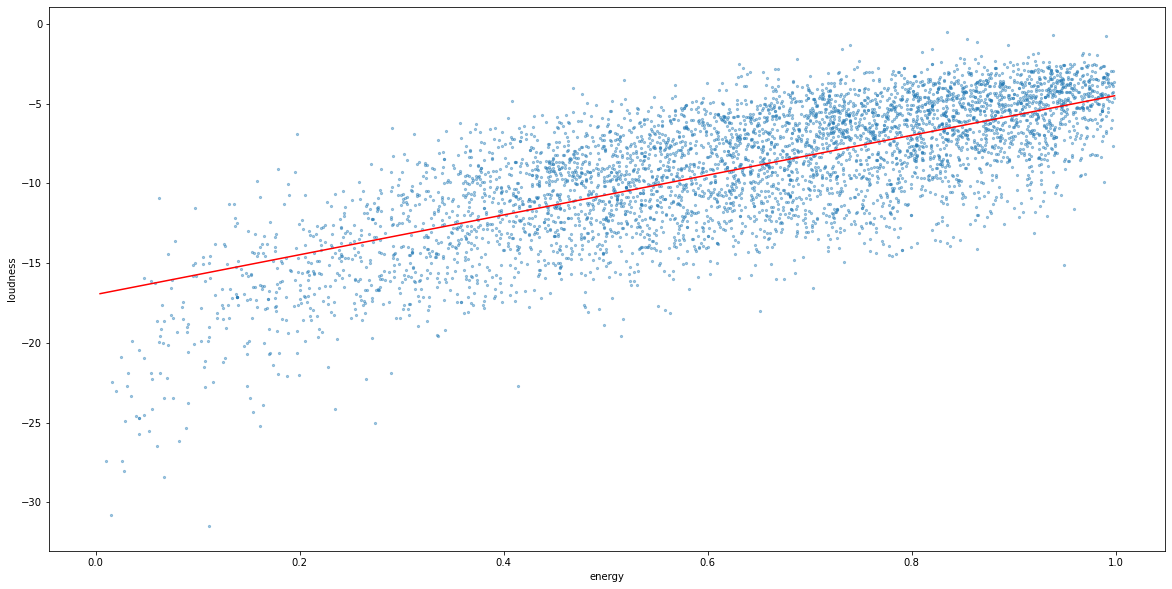

In [20]:
plot_prediction_curve(model_lasso, X_test, y_test)

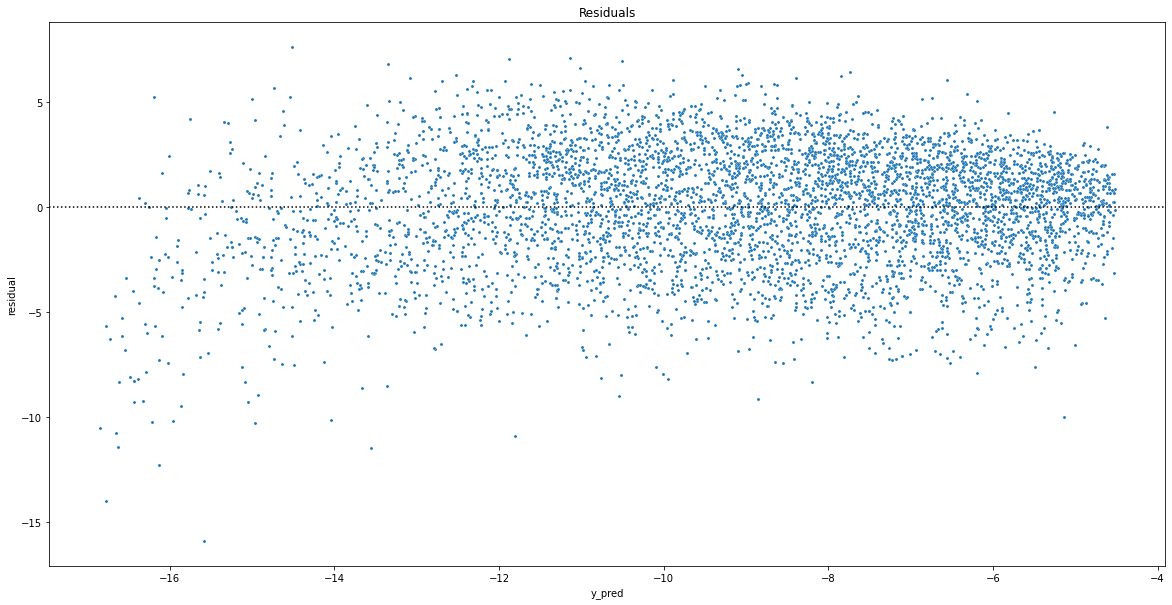

In [21]:
plot_residuals(model_lasso, X_test, y_test)

### Finding best alpha

In [22]:
cls = GridSearchCV(Lasso(), [{'alpha': np.logspace(-4,-0.5,30)}], cv=20, refit=False)
cls.fit(X_train, y_train)
print(f'Best alpha: ', cls.best_params_)

Best alpha:  {'alpha': 0.0016102620275609393}


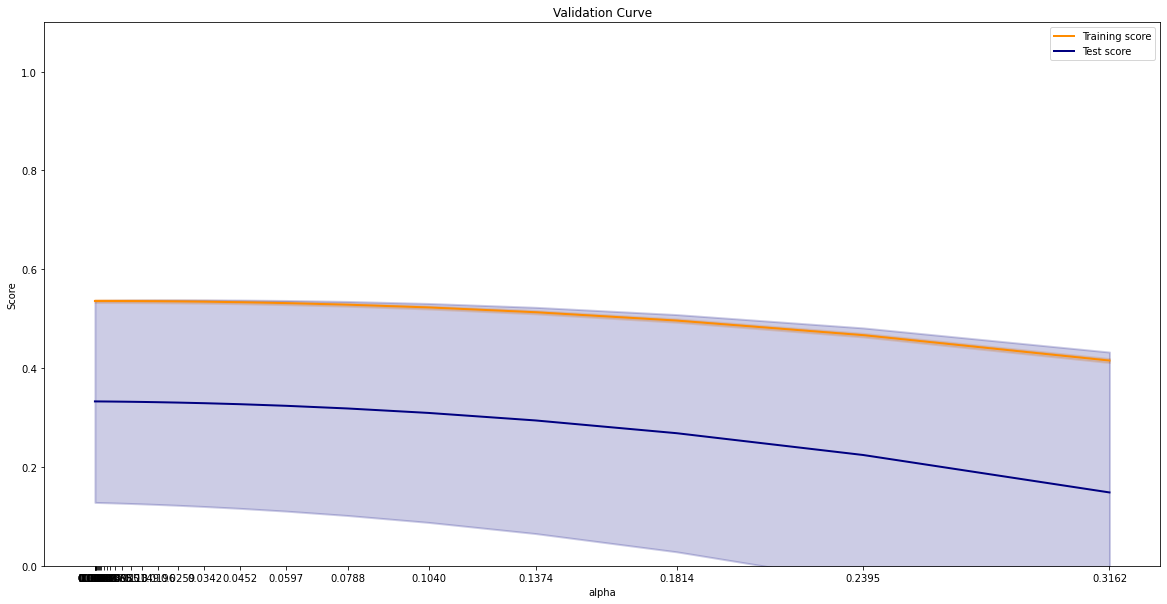

In [23]:
plot_validation_curve(
    Lasso(),
    X,
    y,
    param_name='alpha',
    param_range=np.logspace(-4,-0.5,30),
    cv=20
)

### Conclusion

As best alpha we get the smallest number in the range.  
The validation curve also confirms that the score gets smaller as we increase the alpha.  
This shows that lasso regression doesn't give better results, as it gives the highest score with alpha=0, which is just linear regression.

## Ridge regression


In [24]:
model_ridge = Ridge(0.05)
fit_summary(model_ridge, X_train, X_test, y_train, y_test)

MAE: 2.197262590265011
MSE: 7.543968892361218
R2 score: 0.5510605330924315


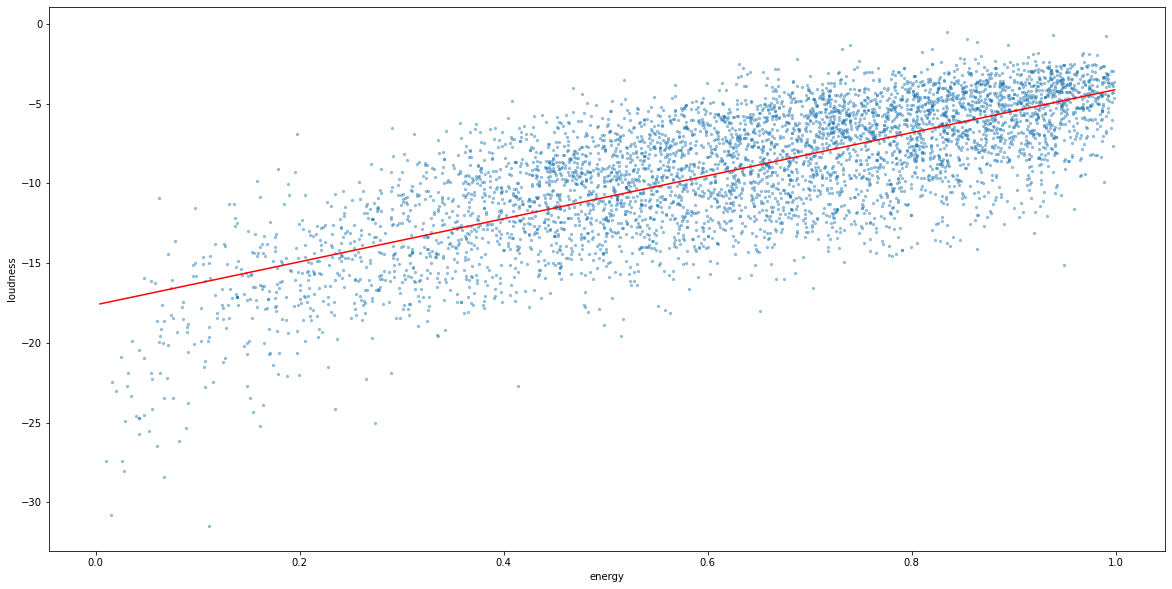

In [25]:
plot_prediction_curve(model_ridge, X_test, y_test)

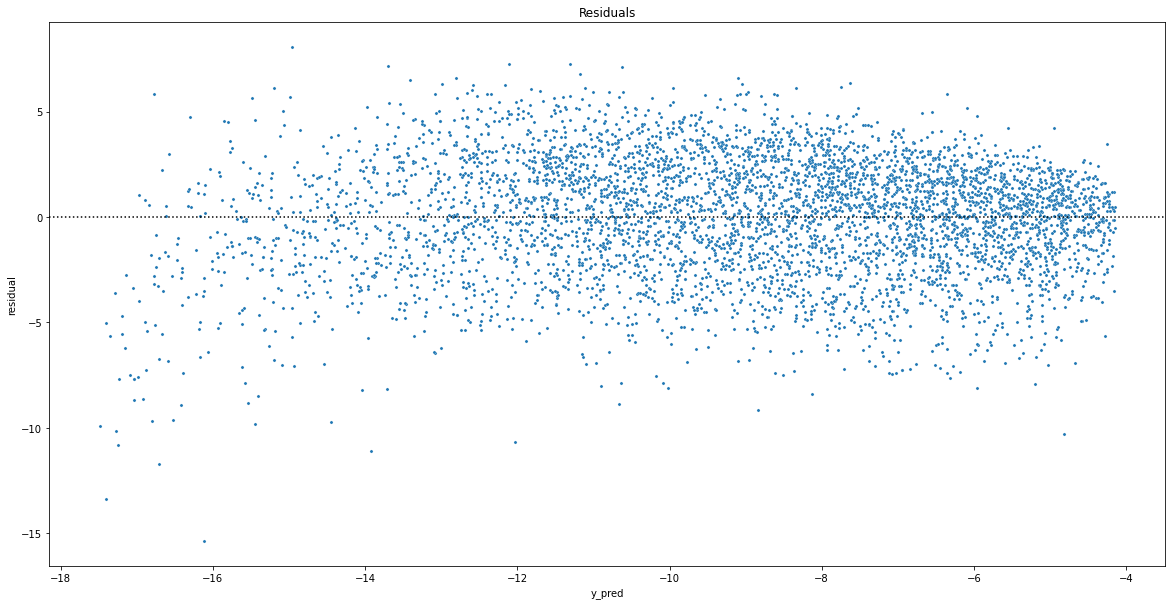

In [26]:
plot_residuals(model_ridge, X_test, y_test)

### Finding best alpha

In [27]:
cls = GridSearchCV(model_ridge, [{'alpha': np.logspace(-4,-0.5,30)}], cv=20, refit=False)
cls.fit(X_train, y_train)
print(f'Best alpha: ',cls.best_params_)

Best alpha:  {'alpha': 0.31622776601683794}


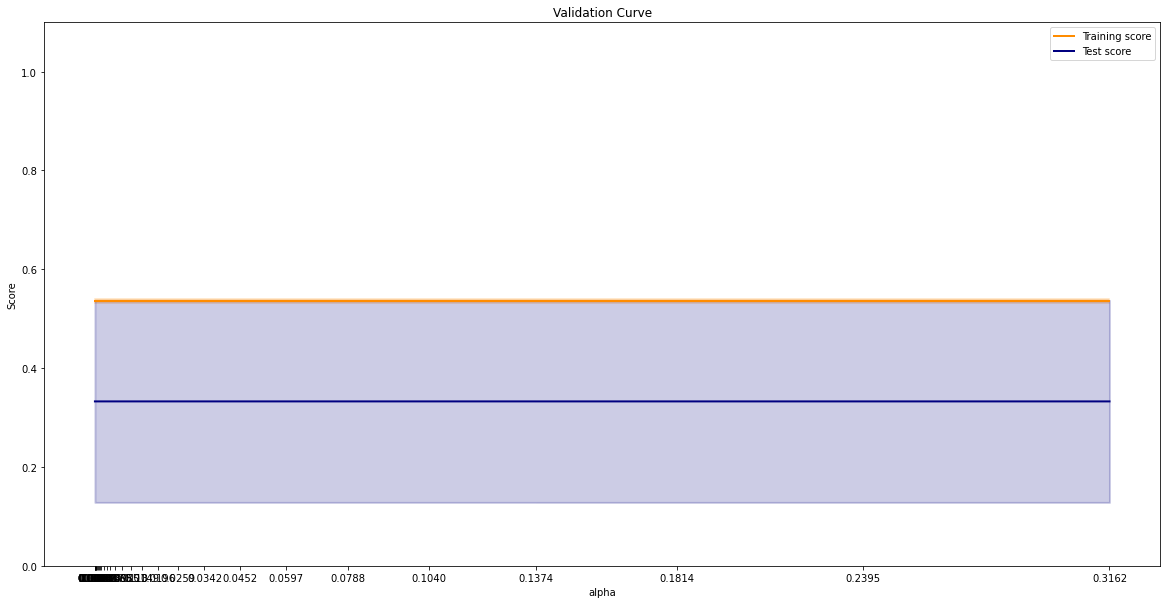

In [28]:
plot_validation_curve(
    Ridge(),
    X,
    y,
    param_name='alpha',
    param_range=np.logspace(-4,-0.5,30),
    cv=20
)

### Conclusion

Here we observe that the alpha parameter has no effect on the score of the ridge regressor.